# Text Similarity with Siamese CNNs and RNNs (TIC-SCNN-SRNN)

This notebook implements the paper:

**“Text similarity based on two independent channels: Siamese Convolutional Neural Networks and Siamese Recurrent Neural Networks”**  
(Neurocomputing, 2025)

The goal is to detect whether two questions are semantically equivalent, using
a dual-channel Siamese architecture that combines:
- a convolutional encoder (SCNN) for local n-gram patterns, and
- a recurrent encoder (SRNN) for sequential semantics.

**Pipeline:**
1. Load and inspect data
2. Tokenize and pad question pairs
3. Initialize word embeddings (GloVe)
4. Build SCNN and SRNN encoders
5. Train the dual-channel Siamese model
6. Evaluate on a held-out test set

The approach is evaluated on a question-pairs dataset, following an end-to-end
pipeline from preprocessing to model training and final evaluation.


In [5]:
import numpy as np
import pandas as pd
from gensim.models import KeyedVectors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Dense, Concatenate, Lambda, Bidirectional, LSTM
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [6]:
import random
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)


## Data Loading and Inspection

We load a question-pairs dataset containing pairs of questions and a binary label
`is_duplicate` indicating whether the two questions are semantically equivalent.


In [7]:
df = pd.read_csv("/kaggle/input/question-pairs-dataset/questions.csv")
df = df.dropna(subset=["question1", "question2"])
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 404348 entries, 0 to 404350
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404348 non-null  int64 
 1   qid1          404348 non-null  int64 
 2   qid2          404348 non-null  int64 
 3   question1     404348 non-null  object
 4   question2     404348 non-null  object
 5   is_duplicate  404348 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 21.6+ MB


## Pretrained Word Embeddings (GloVe)

We initialize word embeddings using 100-dimensional GloVe vectors. These embeddings
provide semantic priors and are further fine-tuned during model training.

In [9]:
w2v = KeyedVectors.load_word2vec_format(
    "/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.100d.txt",
    no_header=True, binary=False
)

In [10]:
tokenizer = Tokenizer(num_words=60000, oov_token="<unk>")
tokenizer.fit_on_texts(df["question1"].tolist() + df["question2"].tolist())

## Train / Validation / Test Split

We split the data into:
- 80% training
- 10% validation
- 10% test

Stratification ensures class balance across splits.


In [11]:
MAX_LEN = 40

q1 = tokenizer.texts_to_sequences(df["question1"])
q2 = tokenizer.texts_to_sequences(df["question2"])

q1 = pad_sequences(q1, maxlen=MAX_LEN, padding="post")
q2 = pad_sequences(q2, maxlen=MAX_LEN, padding="post")

y = df["is_duplicate"].values

q1_train, q1_temp, q2_train, q2_temp, y_train, y_temp = train_test_split(
    q1, q2, y, test_size=0.2, random_state=42, stratify=y
)

q1_val, q1_test, q2_val, q2_test, y_val, y_test = train_test_split(
    q1_temp, q2_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

## Embedding Matrix Construction

We build an embedding matrix aligned with the tokenizer vocabulary. Words found in
GloVe are initialized with pretrained vectors, while out-of-vocabulary tokens are
initialized randomly.


In [12]:
word_index = tokenizer.word_index
embedding_dim = 100

embedding_matrix = np.zeros((60000, embedding_dim))

for word, idx in word_index.items():
    if idx < 60000:
        if word in w2v:
            embedding_matrix[idx] = w2v[word]
        else:
            embedding_matrix[idx] = np.random.normal(0, 0.1, embedding_dim)

## Model Architecture

The model follows the TIC-SCNN-SRNN framework with two independent Siamese channels:

- **SCNN:** captures local n-gram patterns via multiple convolution filters.
- **SRNN:** captures sequential dependencies via stacked bidirectional LSTMs.

Each channel produces a vector representation, and similarity is modeled via
element-wise squared difference.


### Siamese CNN Encoder (SCNN)

In [17]:
def build_scnn(embedding_matrix, max_len):
    input_q = Input(shape=(max_len,))

    embedding = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
        name="Embedding_C"
    )(input_q)

    convs = []
    for f in [3, 4, 5]:
        c = Conv1D(filters=128, kernel_size=f, activation='relu')(embedding)
        c = GlobalMaxPooling1D()(c)
        convs.append(c)

    z = Concatenate()(convs)
    z = Dense(128, activation="relu")(z)

    model = Model(inputs=input_q, outputs=z, name="SCNN_encoder")
    return model

### Siamese RNN Encoder (SRNN)

In [18]:
def build_srnn(embedding_matrix, max_len):
    input_q = Input(shape=(max_len,))

    embedding = Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=max_len,
        trainable=True,
        name="Embedding_R"
    )(input_q)

    x = Bidirectional(LSTM(128, return_sequences=True))(embedding)
    x = Bidirectional(LSTM(128, return_sequences=True))(x)
    x = Bidirectional(LSTM(64))(x)

    out = Dense(128, activation="relu")(x)

    model = Model(inputs=input_q, outputs=out, name="SRNN_encoder")
    return model

### Dual-Channel TIC Model

Both channels are trained jointly, each with its own sigmoid output. The total loss
is a weighted sum of the SCNN and SRNN losses.


In [19]:
def siamese_distance(vects):
    x, y = vects
    return K.square(x - y)

def build_tic_model(embedding_matrix, max_len, alpha=1.0, beta=1.0):

    scnn = build_scnn(embedding_matrix, max_len)
    srnn = build_srnn(embedding_matrix, max_len)

    q1 = Input(shape=(max_len,))
    q2 = Input(shape=(max_len,))

    scnn_out1 = scnn(q1)
    scnn_out2 = scnn(q2)
    srnn_out1 = srnn(q1)
    srnn_out2 = srnn(q2)

    diff_cnn = Lambda(siamese_distance)([scnn_out1, scnn_out2])
    diff_rnn = Lambda(siamese_distance)([srnn_out1, srnn_out2])

    y_cnn = Dense(1, activation="sigmoid", name="y_sc")(diff_cnn)
    y_rnn = Dense(1, activation="sigmoid", name="y_sr")(diff_rnn)

    model = Model(inputs=[q1, q2], outputs=[y_cnn, y_rnn])

    model.compile(
        loss={"y_sc": "binary_crossentropy", "y_sr": "binary_crossentropy"},
        loss_weights={"y_sc": alpha, "y_sr": beta},
        optimizer="adam"
    )

    return model

## Model Training

The model is trained using binary cross-entropy loss for both channels and optimized
with Adam. Early stopping is applied to prevent overfitting.


In [20]:
model = build_tic_model(embedding_matrix, MAX_LEN, alpha=1.0, beta=1.0)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    [q1_train, q2_train],
    {"y_sc": y_train, "y_sr": y_train},
    batch_size=128,
    epochs=50,
    validation_data=([q1_val, q2_val], {"y_sc": y_val, "y_sr": y_val}),
    callbacks=[early_stopping]
)

Epoch 1/50


I0000 00:00:1766946258.774354     138 cuda_dnn.cc:529] Loaded cuDNN version 90300


2528/2528 ━━━━━━━━━━━━━━━━━━━━ 165s 61ms/step - loss: 1.0726 - y_sc_loss: 0.5118 - y_sr_loss: 0.5608 - val_loss: 0.8711 - val_y_sc_loss: 0.4153 - val_y_sr_loss: 0.4557
Epoch 2/50
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 153s 60ms/step - loss: 0.7871 - y_sc_loss: 0.3602 - y_sr_loss: 0.4269 - val_loss: 0.8455 - val_y_sc_loss: 0.4159 - val_y_sr_loss: 0.4296
Epoch 3/50
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 153s 60ms/step - loss: 0.6138 - y_sc_loss: 0.2577 - y_sr_loss: 0.3561 - val_loss: 0.9070 - val_y_sc_loss: 0.4725 - val_y_sr_loss: 0.4345
Epoch 4/50
2528/2528 ━━━━━━━━━━━━━━━━━━━━ 153s 60ms/step - loss: 0.4858 - y_sc_loss: 0.1839 - y_sr_loss: 0.3019 - val_loss: 1.0233 - val_y_sc_loss: 0.5773 - val_y_sr_loss: 0.4460


## Learning Curves

We visualize training and validation loss over epochs to assess convergence
behavior and potential overfitting of the dual-channel Siamese model.


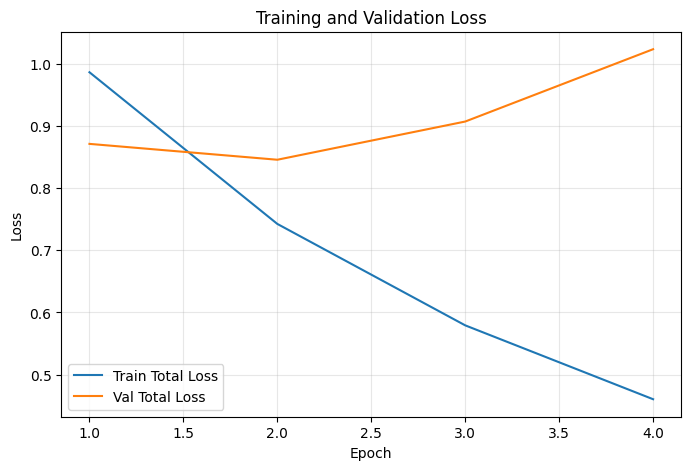

In [21]:
history_dict = history.history
epochs = range(1, len(history_dict["loss"]) + 1)

plt.figure(figsize=(8, 5))
plt.plot(epochs, history_dict["loss"], label="Train Total Loss")
plt.plot(epochs, history_dict["val_loss"], label="Val Total Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

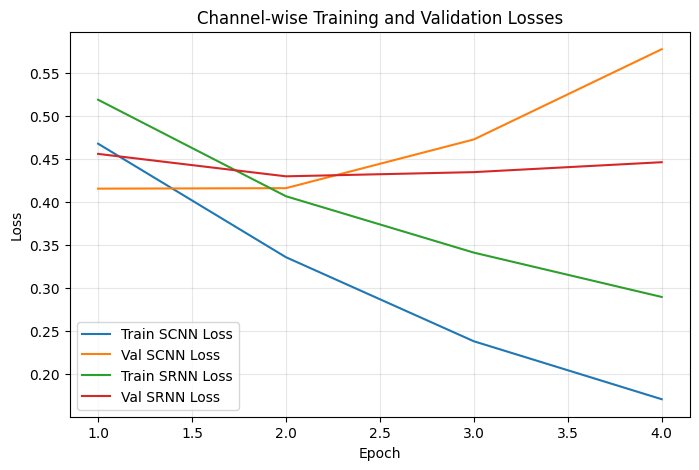

In [22]:
plt.figure(figsize=(8, 5))

plt.plot(epochs, history_dict["y_sc_loss"], label="Train SCNN Loss")
plt.plot(epochs, history_dict["val_y_sc_loss"], label="Val SCNN Loss")

plt.plot(epochs, history_dict["y_sr_loss"], label="Train SRNN Loss")
plt.plot(epochs, history_dict["val_y_sr_loss"], label="Val SRNN Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Channel-wise Training and Validation Losses")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

## Evaluation

Predictions from both channels are averaged to form the final similarity score.
A threshold of 0.5 is used for binary classification.


316/316 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step


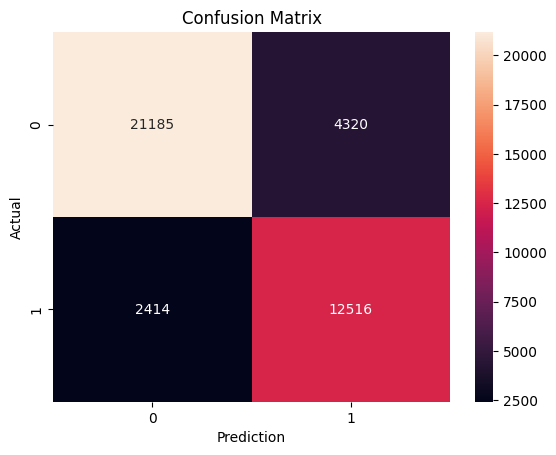

              precision    recall  f1-score   support

           0       0.90      0.83      0.86     25505
           1       0.74      0.84      0.79     14930

    accuracy                           0.83     40435
   macro avg       0.82      0.83      0.83     40435
weighted avg       0.84      0.83      0.84     40435



In [23]:
test_sc, test_sr = model.predict([q1_test, q2_test], batch_size=128)
combined = (test_sc + test_sr)/2.0
test_pred = (combined.reshape(-1) >= 0.5).astype(int)

cm = confusion_matrix(y_test, test_pred)

sns.heatmap(cm, annot=True, fmt='g')
plt.ylabel('Actual')
plt.xlabel('Prediction')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(y_test, test_pred))

The model achieves an overall accuracy of **83%** on the held-out test set.

Key observations:
- High recall for the *duplicate* class (0.84) indicates strong ability to
  identify semantically equivalent questions.
- Precision for duplicates (0.74) suggests some false positives, reflecting the
  intrinsic ambiguity of natural language similarity.
- Performance on the *non-duplicate* class is stronger, with precision of 0.90.

Overall, the model provides a good balance between detecting duplicates and
rejecting unrelated pairs, making it suitable for practical text matching tasks.

## Inference: Predicting Similarity for New Question Pairs

In this section, we demonstrate how to use the trained model to predict whether
two new questions are semantically equivalent. This simulates real-world usage
in applications such as FAQ deduplication, search, or question matching.


In [24]:
def predict_similarity(q1_text, q2_text, tokenizer, model, max_len=20, threshold=0.5):
    """
    Predict whether two questions are duplicates.

    Args:
        q1_text (str): First question
        q2_text (str): Second question
        tokenizer: fitted Keras tokenizer
        model: trained TIC-SCNN-SRNN model
        max_len (int): maximum sequence length
        threshold (float): decision threshold

    Returns:
        prob (float): predicted similarity probability
        pred (int): binary prediction (1=duplicate, 0=not duplicate)
    """
    seq1 = tokenizer.texts_to_sequences([q1_text])
    seq2 = tokenizer.texts_to_sequences([q2_text])

    seq1 = pad_sequences(seq1, maxlen=max_len, padding="post")
    seq2 = pad_sequences(seq2, maxlen=max_len, padding="post")

    sc_pred, sr_pred = model.predict([seq1, seq2], verbose=0)
    prob = float((sc_pred + sr_pred) / 2.0)

    pred = int(prob >= threshold)
    return prob, pred

In [25]:
examples = [
    ("How can I learn machine learning?", "What is the best way to study ML?"),
    ("What is the capital of France?", "How to cook pasta at home?"),
    ("How do I reset my password?", "How can I change my account password?")
]

for q1_text, q2_text in examples:
    prob, pred = predict_similarity(q1_text, q2_text, tokenizer, model, MAX_LEN)
    label = "Duplicate" if pred == 1 else "Not duplicate"
    print(f"Q1: {q1_text}")
    print(f"Q2: {q2_text}")
    print(f"Similarity probability: {prob:.3f} → {label}")
    print("-" * 60)

Q1: How can I learn machine learning?
Q2: What is the best way to study ML?
Similarity probability: 0.055 → Not duplicate
------------------------------------------------------------
Q1: What is the capital of France?
Q2: How to cook pasta at home?
Similarity probability: 0.000 → Not duplicate
------------------------------------------------------------
Q1: How do I reset my password?
Q2: How can I change my account password?
Similarity probability: 0.840 → Duplicate
------------------------------------------------------------
